In [1]:
import pandas as pd
import sys
import os
import random
import pickle


import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import plotly
sys.path.append('../')
from feature_engineering import feature_engineering
from data_loader import lgbm_data_loader, ctb_data_loader, category_data_loader

import warnings

warnings.filterwarnings("ignore")

/opt/conda/envs/lgbm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
IS_CUSTOM = True
USE_VALID = True
USE_PCA = False
valid_len = 2
n_components = 10

DROPS = [
    'Timestamp','year','day','minute','second','KnowledgeTag',
]
PCA = [
    # 'hour_answerCode_sum',
    # 'userID_dayofweek_answerCode_count',
    # 'user_correct_answer',
    # 'user_total_answer',
    # 'hour_answerCode_var',
    # 'hour_answerCode_mean',
    # 'userID_first3_answerCode_count',
    # 'userID_month_answerCode_count',
    # 'KnowledgeTag_first3_answerCode_sum',
    # 'KnowledgeTag',
    # 'userID_answerCode_count',
    # 'userID_answerCode_sum',
    # 'testId_answerCode_sum',
    # 'KnowledgeTag_answerCode_count',
    # 'KnowledgeTag_answerCode_sum',
    # 'month',
    # 'hour',
    # 'dayofweek',
    # 'dayofweek_answerCode_mean',
    # 'dayofweek_answerCode_count',
    # 'dayofweek_answerCode_sum',
    # 'dayofweek_answerCode_var',
    # 'mid3',
    # 'KnowledgeTag_first3_answerCode_mean',
    # 'KnowledgeTag_first3_answerCode_count',
    # 'month_answerCode_var',
    # 'month_answerCode_count',
    # 'hour_answerCode_count', 
    # 'KnowledgeTag_first3_answerCode_var',
]

In [18]:
# train, valid, y_train, y_valid, test = lgbm_data_loader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len)
# train, valid, y_train, y_valid, test = ctb_data_loader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len, n_components=n_components)
# train, valid, y_train, y_valid, test = ctb_dtrain, valid, y_train, y_valid, test, ids_of_categorical = category_data_loader(IS_CUSTOM=IS_CUSTOM, USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len,PCA=PCA, n_components=5, USE_PCA=USE_PCA)
train, valid, y_train, y_valid, test, ids_of_categorical = category_data_loader(IS_CUSTOM=IS_CUSTOM, USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len,PCA=PCA, n_components=n_components, USE_PCA=USE_PCA)

Label Encoding...: 100%|██████████| 69/69 [00:17<00:00,  4.05it/s]


Start binning


Binning...: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


In [19]:
lgb_train = lgb.Dataset(train, y_train)
lgb_valid = lgb.Dataset(valid, y_valid)

In [20]:
"""
{'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}
'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400
'max_depth': 3, 'learning_rate': 0.006598711072054081, 'n_estimators': 2514, 'min_child_samples': 25, 'subsample': 0.4725148048142631
"""
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        "eval_metric":"auc",
        'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 376, 'feature_fraction': 0.6387926357773329, 'bagging_fraction': 0.24041677639819287, 'bagging_freq': 2, 'min_child_samples': 6,
        'max_depth': 7, 'learning_rate': 0.0005061576888752304, 'n_estimators': 2223, 'min_child_samples': 62, 'subsample': 0.46147273880126555,
    } 
valid_sets = [lgb_train, lgb_valid] if USE_VALID else [lgb_train]
model = lgb.train(
    params,
    lgb_train,
    categorical_feature=ids_of_categorical,
    valid_sets=valid_sets,
    verbose_eval=10,
    early_stopping_rounds=30,
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Info] Number of positive: 1618694, number of negative: 855048
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27911
[LightGBM] [Info] Number of data points in the train set: 2473742, number of used features: 62
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.461

In [21]:
preds = model.predict(valid)
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

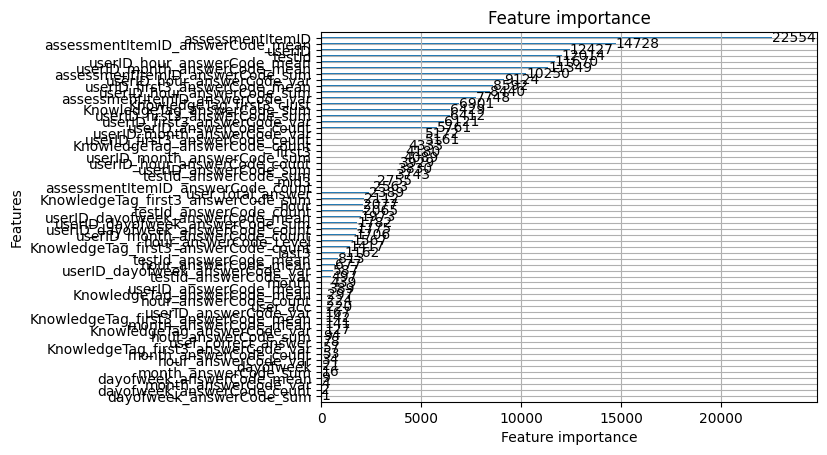

In [22]:
_ = lgb.plot_importance(model)

In [23]:
# LOAD TESTDATA
# FEATURE ENGINEERING
# LEAVE LAST INTERACTION ONLY
# DROP ANSWERCODE
# MAKE PREDICTION
total_preds = model.predict(test.drop(["answerCode"], axis=1))
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "lgbm_submission.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))
def get_accuracy(PRED_PATH="lgbm_submission.csv"):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"
if IS_CUSTOM:
    print(get_accuracy("output/" + "lgbm_submission.csv"))


writing prediction : output/lgbm_submission.csv
accuracy_score: 0.7217741935483871
roc  auc_score: 0.8093750685793288


### Optuna example

In [24]:
def objective(trial: Trial):
    # params = {
    #     'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.8, step=0.01),
    #     'bagging_seed': trial.suggest_categorical("seed", [11, 42]), ##
    #     'learning_rate': trial.suggest_categorical("lr", [0.001, 0.005, 0.01, 0.05, 0.1]),
    #     'num_iterations': trial.suggest_int("n_iter", 100, 1500, 100),
    #     'max_depth': trial.suggest_categorical('max_depth', [-1, 1, 2]), # need to consider
    #     'early_stopping': trial.suggest_int('patience', 5, 40, 5),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8, step=0.01),
    #     'num_leaves': trial.suggest_int('num_leaves', 100, 500, 50),
    #     'min_child_weight': 0.03454472573214212,
    #     'reg_alpha': 0.3899927210061127,
    #     'reg_lambda': 0.6485237330340494,
    #     'random_state': 47,
    #     "verbosity": -1,
    #     'boost_from_average' : False,
    #     'colsample_bytree':[0.5,0.75],
    # }
    #calsam

    # param = {
    #     'objective': 'binary',
    #     'boosting': 'gbdt',
    #     'verbose': -1,
    #     'max_depth': trial.suggest_int('max_depth',3, 15),
    #     'learning_rate': trial.suggest_loguniform("learning_rate", 1e-7, 1e-2),
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
    #     'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    #     'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    #     'force_row_wise':True,
    #     'force_col_wise':True,
    # }
    param = {
        "objective": "binary",
        "boosting_type": "gbdt",                
        # 'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # 'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        # 'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),

        "n_jobs":-1,
        "verbosity": -1,
    }

    model = lgb.train(
        params,
        lgb_train,
        categorical_feature=ids_of_categorical,
        valid_sets=[lgb_train, lgb_valid],
        verbose_eval=100,
        early_stopping_rounds=25,
        # categorical_feature=ids_of_categorical,
    )

    preds = model.predict(valid)
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    return auc
if USE_VALID and IS_CUSTOM:
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
        study_name="lgbm_parameter_opt",
        direction="maximize",
        sampler=sampler,
    )
    study.optimize(objective, n_trials=1)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)

[I 2022-12-01 16:47:54,063] A new study created in memory with name: lgbm_parameter_opt


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46147273880126555 will be ignored. Current value: bagging_fraction=0.24041677639819287
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.24041677639819287, subsample=0.46

[I 2022-12-01 16:53:56,921] Trial 0 finished with value: 0.8588122870037763 and parameters: {'max_depth': 7, 'learning_rate': 0.005061576888752304, 'n_estimators': 2223, 'min_child_samples': 62, 'subsample': 0.46147273880126555}. Best is trial 0 with value: 0.8588122870037763.


Best Score: 0.8588122870037763
Best trial: {'max_depth': 7, 'learning_rate': 0.005061576888752304, 'n_estimators': 2223, 'min_child_samples': 62, 'subsample': 0.46147273880126555}


In [25]:
# with open("LGBM_BEST.pickle", "wb") as fw:
#     pickle.dump(study.best_trial.params, fw)
#     fw.close()

In [26]:
# # load data
# with open('LGBM_BEST.pickle', 'rb') as fr:
#     user_loaded = pickle.load(fr)
#     fr.close()
# # show data
# print(user_loaded)

In [27]:
# optuna.visualization.plot_param_importances(study)

In [28]:
# optuna.visualization.plot_optimization_history(study)

In [29]:
# 'hour_answerCode_median', 
# 'dayofweek_answerCode_median', 
# 'KnowledgeTag_answerCode_median', 
# 'userID_answerCode_median', 
# 'month_answerCode_median'

In [30]:
# LOAD TESTDATA
# FEATURE ENGINEERING
# LEAVE LAST INTERACTION ONLY
# DROP ANSWERCODE
# MAKE PREDICTION
total_preds = model.predict(test.drop(["answerCode"], axis=1))
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "lgbm_submission.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))
def get_accuracy(PRED_PATH="lgbm_submission.csv"):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"
if IS_CUSTOM:
    print(get_accuracy("output/" + "lgbm_submission.csv"))


writing prediction : output/lgbm_submission.csv
accuracy_score: 0.7217741935483871
roc  auc_score: 0.8093750685793288
